In [ ]:
# Cell 1: Mount Google Drive & Define Path
from google.colab import drive
import os
drive.mount('/content/drive')

NEW_MODEL_DIR = '/content/drive/My Drive/DeepFakeDataset/NEW MODELS/NEW'
os.makedirs(NEW_MODEL_DIR, exist_ok=True)
print(f"✅ Models will be saved in: {NEW_MODEL_DIR}")

Mounted at /content/drive
✅ Models will be saved in: /content/drive/My Drive/DeepFakeDataset/NEW MODELS/NEW


In [ ]:
# Cell 2: Unzip BOTH Datasets
import os

print("--- Step 1: Unzipping Datasets ---")

DRIVE_ZIP_PATH_REAL = '/content/drive/My Drive/DeepFakeDataset/140k-real-and-fake-faces.zip'
LOCAL_DATA_PATH_REAL = '/content/dataset_140k'

DRIVE_ZIP_PATH_FAKE = '/content/drive/My Drive/DeepFakeDataset/stable-diffusion.zip'
LOCAL_DATA_PATH_FAKE = '/content/dataset_stable-diffusion'

if not os.path.exists(os.path.join(LOCAL_DATA_PATH_REAL, 'real_vs_fake')):
    print("Unzipping 140k Real dataset...")
    !rm -rf "{LOCAL_DATA_PATH_REAL}"
    os.makedirs(LOCAL_DATA_PATH_REAL, exist_ok=True)
    !unzip -q "{DRIVE_ZIP_PATH_REAL}" -d "{LOCAL_DATA_PATH_REAL}"
else:
    print("140k Real dataset already unzipped.")

if not os.path.exists(os.path.join(LOCAL_DATA_PATH_FAKE, 'stable-diffusion')):
    print("Unzipping stable-diffusion FAKE dataset...")
    !rm -rf "{LOCAL_DATA_PATH_FAKE}"
    os.makedirs(LOCAL_DATA_PATH_FAKE, exist_ok=True)
    !unzip -q "{DRIVE_ZIP_PATH_FAKE}" -d "{LOCAL_DATA_PATH_FAKE}"
else:
    print("stable-diffusion FAKE dataset already unzipped.")

print("✅ All data ready for training.\n")

--- Step 1: Unzipping Datasets ---
Unzipping 140k Real dataset...
Unzipping stable-diffusion FAKE dataset...
✅ All data ready for training.



In [ ]:
# Cell 3: VERIFY Unzipped Structure
print("--- Verifying top 50 lines of FAKE dataset ---")
!ls -lR '/content/dataset_stable-diffusion' | head -n 50

--- Verifying top 50 lines of FAKE dataset ---
/content/dataset_stable-diffusion:
total 332
drwxrwxrwx 2 root root 335872 Nov  1 16:10 stable-diffusion

/content/dataset_stable-diffusion/stable-diffusion:
total 5626352
-rw-rw-rw- 1 root root   49082 Nov  1 16:10 image_0.jpg
-rw-rw-rw- 1 root root   41837 Nov  1 16:10 image_100_0.jpg
-rw-rw-rw- 1 root root   54027 Nov  1 16:10 image_100_1.jpg
-rw-rw-rw- 1 root root   40655 Nov  1 16:10 image_100_2.jpg
-rw-rw-rw- 1 root root   53733 Nov  1 16:10 image_100_3.jpg
-rw-rw-rw- 1 root root   84202 Nov  1 16:10 image_10_0.jpg
-rw-rw-rw- 1 root root   37008 Nov  1 16:10 image_101_0.jpg
-rw-rw-rw- 1 root root   60459 Nov  1 16:10 image_101_1.jpg
-rw-rw-rw- 1 root root   57268 Nov  1 16:10 image_101_2.jpg
-rw-rw-rw- 1 root root   70695 Nov  1 16:10 image_101_3.jpg
-rw-rw-rw- 1 root root  106477 Nov  1 16:10 image_10_1.jpg
-rw-rw-rw- 1 root root   74522 Nov  1 16:10 image_102_0.jpg
-rw-rw-rw- 1 root root   54033 Nov  1 16:10 image_102_1.jpg
-rw-rw-

In [ ]:
# Cell 4: Define the ImageDataset Class
import torch
from torch.utils.data import Dataset
import cv2

class ImageDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        img = cv2.imread(img_path)

        if img is None:
            print(f"Warning: Could not read image {img_path}. Skipping.")
            return torch.zeros((3, 224, 224)), torch.tensor(label, dtype=torch.long)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)

print("ImageDataset class defined.")

ImageDataset class defined.


In [ ]:
# Cell 5: Define the SimpleCNN Model Architecture (with Regularization)
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()

        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

print("SimpleCNN model class defined.")

SimpleCNN model class defined.


In [ ]:
# Cell 6: Create the Data Loaders
import glob
from torchvision import transforms
from torch.utils.data import DataLoader
import os
import random
from sklearn.model_selection import train_test_split

print("\n--- Step 2: Preparing Data Loaders ---")

REAL_DATA_PATH = '/content/dataset_140k/real_vs_fake/real-vs-fake'
real_files = glob.glob(os.path.join(REAL_DATA_PATH, 'train/real', '*.jpg')) + \
             glob.glob(os.path.join(REAL_DATA_PATH, 'valid/real', '*.jpg'))
print(f"Found {len(real_files)} total REAL images.")

FAKE_DATA_PATH = '/content/dataset_stable-diffusion/stable-diffusion'
fake_files = glob.glob(os.path.join(FAKE_DATA_PATH, '*.jpg'))
print(f"Found {len(fake_files)} total FAKE (stable-diffusion) images.")

if len(fake_files) == 0:
    print("❌ ERROR: No fake files found. Cannot continue.")
    print(f"Please check the path: {FAKE_DATA_PATH}")
else:
    real_files_balanced = random.sample(real_files, len(fake_files))
    print(f"Balancing dataset: Using {len(real_files_balanced)} REAL images.")

    all_files_list = [(path, 0) for path in fake_files] + \
                     [(path, 1) for path in real_files_balanced]

    labels = [label for path, label in all_files_list]
    train_list, valid_list = train_test_split(
        all_files_list,
        test_size=0.20,
        random_state=42,
        stratify=labels
    )

    print(f"Found {len(all_files_list)} total balanced images.")
    print(f"Split into {len(train_list)} training images.")
    print(f"Split into {len(valid_list)} validation images.")

    im_size = 224
    mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

    data_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((im_size, im_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    train_data = ImageDataset(train_list, transform=data_transforms)
    valid_data = ImageDataset(valid_list, transform=data_transforms)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=2)

    print("✅ Data loaders are ready.\n")


--- Step 2: Preparing Data Loaders ---
Found 60000 total REAL images.
Found 2533 total FAKE (stable-diffusion) images.
Balancing dataset: Using 2533 REAL images.
Found 5066 total balanced images.
Split into 4052 training images.
Split into 1014 validation images.
✅ Data loaders are ready.



In [ ]:
# Cell 7: Train the Model
import torch.optim as optim
from tqdm import tqdm
import time

print("--- Step 3: Setting Up for Training ---")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

MODEL_DIR = '/content/drive/My Drive/DeepFakeDataset/NEW MODELS/NEW'
MODEL_NAME = 'stable-diffusion-simple-cnn-v2'

BEST_MODEL_PATH = os.path.join(MODEL_DIR, f'{MODEL_NAME}_best_model.pth')
CHECKPOINT_PATH = os.path.join(MODEL_DIR, f'{MODEL_NAME}_checkpoint.pth')

print(f"Models and checkpoints will be saved in: {MODEL_DIR}")

model = SimpleCNN().to(device)
lr = 1e-4
num_epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

patience = 3
epochs_no_improve = 0
best_valid_acc = 0.0
start_epoch = 0

if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_valid_acc = checkpoint.get('best_valid_acc', 0.0)
    epochs_no_improve = checkpoint.get('epochs_no_improve', 0)
    print(f"✅ Checkpoint found. Resuming training from epoch {start_epoch}")
else:
    print("ℹ️ No checkpoint found. Starting training from scratch.")

print(f"Training for {num_epochs} total epochs on device: {device}\n")

total_train_time = 0.0

for epoch in range(start_epoch, num_epochs):
    epoch_start_time = time.time()

    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = running_corrects.double() / len(train_loader.dataset)

    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    valid_loss = running_loss / len(valid_loader.dataset)
    valid_acc = running_corrects.double() / len(valid_loader.dataset)

    epoch_time = time.time() - epoch_start_time
    total_train_time += epoch_time

    print(f"Epoch {epoch+1}/{num_epochs} ({epoch_time:.2f}s) | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Valid Loss: {valid_loss:.4f} Acc: {valid_acc:.4f}")

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"🎉 New best model saved with accuracy: {best_valid_acc:.4f}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"Validation accuracy did not improve. Patience: {epochs_no_improve}/{patience}")

    checkpoint_data = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_valid_acc': best_valid_acc,
        'epochs_no_improve': epochs_no_improve
    }
    torch.save(checkpoint_data, CHECKPOINT_PATH)
    print(f"💾 Checkpoint saved for epoch {epoch+1}.\n")

    if epochs_no_improve >= patience:
        print(f"--- 🛑 Early stopping triggered after {patience} epochs with no improvement. ---")
        break

print(f"--- TRAINING COMPLETE ---")
print(f"Total training time: {total_train_time:.2f} seconds")
print(f"Best model saved to: {BEST_MODEL_PATH}")

--- Step 3: Setting Up for Training ---
Models and checkpoints will be saved in: /content/drive/My Drive/DeepFakeDataset/NEW MODELS/NEW
ℹ️ No checkpoint found. Starting training from scratch.
Training for 10 total epochs on device: cuda



Epoch 1/10 [Valid]: 100%|██████████| 32/32 [00:05<00:00,  6.29it/s]


Epoch 1/10 (28.54s) | Train Loss: 0.1203 Acc: 0.9563 | Valid Loss: 0.0334 Acc: 0.9862
🎉 New best model saved with accuracy: 0.9862
💾 Checkpoint saved for epoch 1.



Epoch 2/10 [Valid]: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s]


Epoch 2/10 (28.42s) | Train Loss: 0.0346 Acc: 0.9894 | Valid Loss: 0.0219 Acc: 0.9901
🎉 New best model saved with accuracy: 0.9901
💾 Checkpoint saved for epoch 2.



Epoch 3/10 [Valid]: 100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


Epoch 3/10 (34.79s) | Train Loss: 0.0168 Acc: 0.9943 | Valid Loss: 0.0354 Acc: 0.9822
Validation accuracy did not improve. Patience: 1/3
💾 Checkpoint saved for epoch 3.



Epoch 4/10 [Valid]: 100%|██████████| 32/32 [00:05<00:00,  6.11it/s]


Epoch 4/10 (31.18s) | Train Loss: 0.0168 Acc: 0.9948 | Valid Loss: 0.0354 Acc: 0.9921
🎉 New best model saved with accuracy: 0.9921
💾 Checkpoint saved for epoch 4.



Epoch 5/10 [Valid]: 100%|██████████| 32/32 [00:04<00:00,  6.54it/s]


Epoch 5/10 (32.42s) | Train Loss: 0.0142 Acc: 0.9951 | Valid Loss: 0.0164 Acc: 0.9941
🎉 New best model saved with accuracy: 0.9941
💾 Checkpoint saved for epoch 5.



Epoch 6/10 [Valid]: 100%|██████████| 32/32 [00:06<00:00,  4.87it/s]


Epoch 6/10 (34.03s) | Train Loss: 0.0127 Acc: 0.9968 | Valid Loss: 0.0191 Acc: 0.9911
Validation accuracy did not improve. Patience: 1/3
💾 Checkpoint saved for epoch 6.



Epoch 7/10 [Valid]: 100%|██████████| 32/32 [00:04<00:00,  6.56it/s]


Epoch 7/10 (31.62s) | Train Loss: 0.0086 Acc: 0.9973 | Valid Loss: 0.0235 Acc: 0.9921
Validation accuracy did not improve. Patience: 2/3
💾 Checkpoint saved for epoch 7.



Epoch 8/10 [Valid]: 100%|██████████| 32/32 [00:04<00:00,  6.60it/s]


Epoch 8/10 (31.45s) | Train Loss: 0.0024 Acc: 0.9993 | Valid Loss: 0.0224 Acc: 0.9901
Validation accuracy did not improve. Patience: 3/3
💾 Checkpoint saved for epoch 8.

--- 🛑 Early stopping triggered after 3 epochs with no improvement. ---
--- TRAINING COMPLETE ---
Total training time: 252.44 seconds
Best model saved to: /content/drive/My Drive/DeepFakeDataset/NEW MODELS/NEW/stable-diffusion-simple-cnn-v2_best_model.pth


In [ ]:
# Cell 8: Load Best Model for Evaluation
print("\n--- Step 4: Evaluating the Best Model ---")

model = SimpleCNN().to(device)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()
print(f"✅ Best {BEST_MODEL_PATH} weights loaded for evaluation.")


--- Step 4: Evaluating the Best Model ---
✅ Best /content/drive/My Drive/DeepFakeDataset/NEW MODELS/NEW/stable-diffusion-simple-cnn-v2_best_model.pth weights loaded for evaluation.


In [ ]:
# Cell 9: Get Predictions and True Labels
from tqdm import tqdm

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(valid_loader, desc="Generating predictions on validation set"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("✅ Predictions generated.")

Generating predictions on validation set: 100%|██████████| 32/32 [00:04<00:00,  6.57it/s]

✅ Predictions generated.


In [ ]:
# Cell 10: Calculate and Show Classification Report
from sklearn.metrics import classification_report

class_names = ['FAKE (stable-diffusion)', 'REAL']
print("\n--- Classification Report (stable-diffusion - SimpleCNN-v2) ---")
print(classification_report(all_labels, all_preds, target_names=class_names))


--- Classification Report (stable-diffusion - SimpleCNN-v2) ---
                         precision    recall  f1-score   support

FAKE (stable-diffusion)       1.00      0.99      0.99       507
                   REAL       0.99      1.00      0.99       507

               accuracy                           0.99      1014
              macro avg       0.99      0.99      0.99      1014
           weighted avg       0.99      0.99      0.99      1014




--- Confusion Matrix (stable-diffusion - SimpleCNN-v2) ---


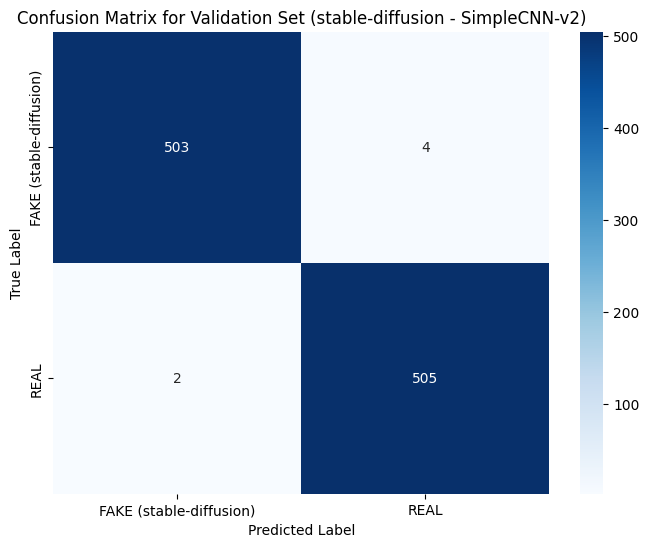

In [ ]:
# Cell 11: Calculate and Plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

print("\n--- Confusion Matrix (stable-diffusion - SimpleCNN-v2) ---")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Validation Set (stable-diffusion - SimpleCNN-v2)')
plt.show()